In [3]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    

SEED = 42
set_seed(SEED)

In [5]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

Check train samples

In [6]:
print(f"Train shape: {train_df.shape}")
train_df.sample(3)

Train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S


In [7]:
print(f"Test shape: {test_df.shape}")
test_df.sample(3)

Test shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
20,912,1,"Rothschild, Mr. Martin",male,55.00,1,0,PC 17603,59.40,NaN,C
338,1230,2,"Denbury, Mr. Herbert",male,25.00,0,0,C.A. 31029,31.50,NaN,S
250,1142,2,"West, Miss. Barbara J",female,0.92,1,2,C.A. 34651,27.75,NaN,S


In [8]:
full_df = pd.concat(
    [
        train_df.drop(["PassengerId", "Survived"], axis=1), 
        test_df.drop(["PassengerId"], axis=1),
    ]
)
y_train = train_df["Survived"].values

In [9]:
full_df.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [10]:
full_df = full_df.drop(["Age", "Cabin"], axis=1)

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


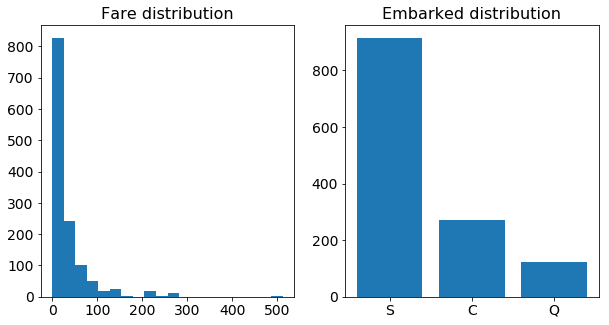

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(full_df["Fare"], bins=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Fare distribution", fontsize=16)

plt.subplot(1, 2, 2)
embarked_info = full_df["Embarked"].value_counts()
plt.bar(embarked_info.index, embarked_info.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Embarked distribution", fontsize=16);

In [12]:
full_df["Embarked"].fillna("S", inplace=True)
full_df["Fare"].fillna(full_df["Fare"].mean(), inplace=True)

In [13]:
full_df["Title"] = full_df["Name"].str.extract(" ([A-Za-z]+)\.")
full_df["Title"] = full_df["Title"].replace(["Ms", "Mlle"], "Miss")
full_df["Title"] = full_df["Title"].replace(["Mme", "Countess", "Lady", "Dona"], "Mrs")
full_df["Title"] = full_df["Title"].replace(["Dr", "Major", "Col", "Sir", "Rev", "Jonkheer", "Capt", "Don"], "Mr")
full_df = full_df.drop(["Name"], axis=1)

In [14]:
full_df["Sex"] = full_df["Sex"].map({"male": 1, "female": 0}).astype(int)    
full_df["Embarked"] = full_df["Embarked"].map({"S": 1, "C": 2, "Q": 3}).astype(int)    
full_df['Title'] = full_df['Title'].map({"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3}).astype(int)   

In [15]:
full_df["TicketNumber"] = full_df["Ticket"].str.split()
full_df["TicketNumber"] = full_df["TicketNumber"].str[-1]
full_df["TicketNumber"] = LabelEncoder().fit_transform(full_df["TicketNumber"])
full_df = full_df.drop(["Ticket"], axis=1)

In [16]:
full_df["FamilySize"] = full_df["SibSp"] + full_df["Parch"] + 1
full_df["IsAlone"] = full_df["FamilySize"].apply(lambda x: 1 if x == 1 else 0)

In [17]:
full_df.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,TicketNumber,FamilySize,IsAlone
0,3,1,1,0,7.2500,1,0,209,2,0
1,1,0,1,0,71.2833,2,2,166,2,0
2,3,0,0,0,7.9250,1,1,466,1,1
3,1,0,1,0,53.1000,1,2,67,2,0
4,3,1,0,0,8.0500,1,0,832,1,1


In [18]:
X_train = full_df[:y_train.shape[0]]
X_test = full_df[y_train.shape[0]:]

print(f"Train X shape: {X_train.shape}")
print(f"Train y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Train X shape: (891, 10)
Train y shape: (891,)
Test X shape: (418, 10)


In [19]:
one_hot_cols = ["Embarked", "Title"]
for col in one_hot_cols:
    full_df = pd.concat(
        [full_df, pd.get_dummies(full_df[col], prefix=col)], 
        axis=1, 
        join="inner",
    )
full_df = full_df.drop(one_hot_cols, axis=1)

In [20]:
scaler = StandardScaler()
full_df.loc[:] = scaler.fit_transform(full_df)

In [21]:
full_df

,Pclass,Sex,SibSp,Parch,Fare,TicketNumber,FamilySize,IsAlone,Embarked_1,Embarked_2,Embarked_3,Title_0,Title_1,Title_2,Title_3
0,0.841916,0.743497,0.481288,-0.445000,-0.503595,-0.846179,0.073352,-1.233758,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
1,-1.546098,-1.344995,0.481288,-0.445000,0.734503,-1.004578,0.073352,-1.233758,-1.526692,1.96167,-0.32204,-1.220079,-0.502625,2.347858,-0.221084
2,0.841916,-1.344995,-0.479087,-0.445000,-0.490544,0.100529,-0.558346,0.810532,0.655011,-0.50977,-0.32204,-1.220079,1.989556,-0.425920,-0.221084
3,-1.546098,-1.344995,0.481288,-0.445000,0.382925,-1.369263,0.073352,-1.233758,0.655011,-0.50977,-0.32204,-1.220079,-0.502625,2.347858,-0.221084
4,0.841916,0.743497,-0.479087,-0.445000,-0.488127,1.448759,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.841916,0.743497,-0.479087,-0.445000,-0.488127,0.347336,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
414,-1.546098,-1.344995,-0.479087,-0.445000,1.461829,-0.938271,-0.558346,0.810532,-1.526692,1.96167,-0.32204,-1.220079,-0.502625,2.347858,-0.221084
415,0.841916,0.743497,-0.479087,-0.445000,-0.503595,0.026855,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
416,0.841916,0.743497,-0.479087,-0.445000,-0.488127,1.183533,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084


In [22]:
X_train_norm = full_df[:y_train.shape[0]]
X_test_norm = full_df[y_train.shape[0]:]

print(f"Train norm X shape: {X_train_norm.shape}")
print(f"Train y shape: {y_train.shape}")
print(f"Test norm X shape: {X_test_norm.shape}")

Train norm X shape: (891, 15)
Train y shape: (891,)
Test norm X shape: (418, 15)


Let's highlight categorical features in one list, since they may be needed for some models

In [23]:
categorical_columns = ['Sex', 'Embarked', 'Title', 'TicketNumber', 'IsAlone']

In [24]:
cross_valid_scores = {}

In [25]:
%%time
parameters = {
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_desicion_tree = DecisionTreeClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_desicion_tree.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_desicion_tree.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{model_desicion_tree.best_score_:.3f}'
)
cross_valid_scores['desicion_tree'] = model_desicion_tree.best_score_
print('-----')

-----
Best parameters {'max_depth': 11}
Mean cross-validated accuracy score of the best_estimator: 0.815
-----
CPU times: user 157 ms, sys: 3.67 ms, total: 161 ms
Wall time: 160 ms


In [26]:
%%time
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_random_forest = RandomForestClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_random_forest = GridSearchCV(
    model_random_forest, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_random_forest.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)
cross_valid_scores['random_forest'] = model_random_forest.best_score_
print('-----')

-----
Best parameters {'max_depth': 9, 'n_estimators': 20}
Mean cross-validated accuracy score of the best_estimator: 0.843
-----
CPU times: user 3.22 s, sys: 0 ns, total: 3.22 s
Wall time: 3.22 s


In [27]:
%%time
parameters = {
    "n_estimators": [5, 10, 15, 20, 25, 50, 75, 100], 
    "learning_rate": [0.001, 0.01, 0.1, 1.],
}

model_adaboost = AdaBoostClassifier(
    random_state=SEED,
)

model_adaboost = GridSearchCV(
    model_adaboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_adaboost.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_adaboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_adaboost.best_score_:.3f}'
)
cross_valid_scores['ada_boost'] = model_adaboost.best_score_
print('-----')

-----
Best parameters {'learning_rate': 1.0, 'n_estimators': 100}
Mean cross-validated accuracy score of the best_estimator: 0.835
-----
CPU times: user 9.2 s, sys: 663 µs, total: 9.2 s
Wall time: 9.2 s


In [28]:
%%time
parameters = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

model_xgb = xgb.XGBClassifier(
    random_state=SEED,
)

model_xgb = GridSearchCV(
    model_xgb, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_xgb.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_xgb.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_xgb.best_score_:.3f}'
)
cross_valid_scores['xgboost'] = model_xgb.best_score_
print('-----')

-----
Best parameters {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}
Mean cross-validated accuracy score of the best_estimator: 0.848
-----
CPU times: user 14.9 s, sys: 220 ms, total: 15.1 s
Wall time: 15.1 s


In [29]:
%%time
parameters = {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [7, 15, 31],
}

model_lgbm = lgbm.LGBMClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_lgbm = GridSearchCV(
    model_lgbm, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_lgbm.fit(
    X_train, 
    y_train, 
    categorical_feature=categorical_columns
)

print('-----')
print(f'Best parameters {model_lgbm.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_lgbm.best_score_:.3f}'
)
cross_valid_scores['lightgbm'] = model_lgbm.best_score_
print('-----')

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked', 'IsAlone', 'Sex', 'TicketNumber', 'Title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


-----
Best parameters {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 15}
Mean cross-validated accuracy score of the best_estimator: 0.828
-----
CPU times: user 7.91 s, sys: 548 ms, total: 8.46 s
Wall time: 8.48 s


In [30]:
%%time
parameters = {
    'iterations': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7, 9, 11, 13],
}

model_catboost = cb.CatBoostClassifier(
    verbose=False,
)

model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_catboost.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)
cross_valid_scores['catboost'] = model_catboost.best_score_
print('-----')

-----
Best parameters {'depth': 11, 'iterations': 100, 'learning_rate': 0.1}
Mean cross-validated accuracy score of the best_estimator: 0.842
-----
CPU times: user 3min 45s, sys: 31.8 s, total: 4min 16s
Wall time: 2min 24s


In [31]:
%%time
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "penalty": ["l1", "l2"]
}

model_logistic_regression = LogisticRegression(
    random_state=SEED,
    class_weight="balanced",
    solver="liblinear",
)

model_logistic_regression = GridSearchCV(
    model_logistic_regression, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_logistic_regression.fit(X_train_norm, y_train)

print('-----')
print(f'Best parameters {model_logistic_regression.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_logistic_regression.best_score_:.3f}'
)
cross_valid_scores['logistic_regression'] = model_logistic_regression.best_score_
print('-----')

-----
Best parameters {'C': 0.01, 'penalty': 'l2'}
Mean cross-validated accuracy score of the best_estimator: 0.801
-----
CPU times: user 258 ms, sys: 668 µs, total: 258 ms
Wall time: 257 ms


In [32]:
%%time
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}

model_svc = SVC(
    random_state=SEED,
    class_weight="balanced",
    probability=True,
)

model_svc = GridSearchCV(
    model_svc, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_svc.fit(X_train_norm, y_train)

print('-----')
print(f'Best parameters {model_svc.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_svc.best_score_:.3f}'
)
cross_valid_scores['svc'] = model_svc.best_score_
print('-----')

-----
Best parameters {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean cross-validated accuracy score of the best_estimator: 0.827
-----
CPU times: user 17.8 s, sys: 0 ns, total: 17.8 s
Wall time: 17.8 s


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [33]:
%%time
parameters = {
    "weights": ["uniform", "distance"],
}

model_k_neighbors = KNeighborsClassifier(
)

model_k_neighbors = GridSearchCV(
    model_k_neighbors, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_k_neighbors.fit(X_train_norm, y_train)

print('-----')
print(f'Best parameters {model_k_neighbors.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_k_neighbors.best_score_:.3f}'
)
cross_valid_scores['k_neighbors'] = model_k_neighbors.best_score_
print('-----')

-----
Best parameters {'weights': 'uniform'}
Mean cross-validated accuracy score of the best_estimator: 0.816
-----
CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 106 ms


In [34]:
pd.DataFrame(cross_valid_scores, index=['cross_valid_score']).T

,cross_valid_score
desicion_tree,0.814815
random_forest,0.842873
ada_boost,0.835017
xgboost,0.848485
lightgbm,0.828283
catboost,0.841751
logistic_regression,0.801347
svc,0.827160
k_neighbors,0.815937
